In [1]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

import mnist

In [2]:
device = mx.gpu
mx.set_default_device(device)
mx.default_device() # Device(gpu, 0)

Device(gpu, 0)

# Dataset

- MNIST dataset contains 60,000 training samples of 28x28 images. 
- These images are reshaped into the size of 784. 
- There are 10 labels (0  to 9)

In [3]:
# read mnist dataset and map into mx array
train_x, train_y, test_x, test_y = map(mx.array, mnist.mnist())

In [4]:
print (type(train_x)) # <class 'mlx.core.array'>
print (train_x.shape) # [60000, 784]
print (train_y.shape) # [60000]
print (test_x.shape) # [10000, 784]

<class 'mlx.core.array'>
[60000, 784]
[60000]
[10000, 784]


# Modeling

In [5]:
class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.dense1 = nn.Linear(num_inputs, 100)
        self.dense2 = nn.Linear(100, num_outputs)
    
    def __call__(self, x):
        out = self.dense1(x)
        out = nn.relu(out)
        out = self.dense2(out)
        return out

In [6]:
# loss function should include the model. I tried to have y_hat and y
# it seems the gradient get reduced to 0. Maybe because the connection loss 
# when y_hat is passed
def loss_fn(model, X, y):
    return mx.mean(nn.losses.cross_entropy(model(X), y))

# Training

In [7]:
# HyperParamters
learning_rate = 5e-3
batch_size = 512
num_epochs = 50
num_steps_per_epoch = train_x.shape[0] // batch_size
num_feature_in = train_x.shape[1]
num_feature_out = 10

print (f"there are {num_steps_per_epoch} steps per epoch")

there are 117 steps per epoch


In [8]:
model = MLP(num_feature_in, num_feature_out)
optimizer = optim.SGD(learning_rate=learning_rate)

# The model is lazy load. Initialization won't build any values
# So, we manually run `mx.eval` to instantiate the model
mx.eval(model.parameters(), optimizer.state)

# get a "function" to compute graident of loss_fn w.r.t. the model parameters
loss_and_grad_fn = nn.value_and_grad(model, loss_fn)

In [9]:
def evaluate(x, y_label):
    n = y_label.shape[0]
    y_pred = model(x)
    y_pred = y_pred.argmax(axis=1)
    score = mx.sum(y_label == y_pred) / n
    return score.item()

In [10]:
num_steps = (train_x.shape[0] // batch_size) * num_epochs
losses = []
accuracy = []

# start with an eval
score = evaluate(test_x, test_y)
accuracy.append(score)
print(f"epoch: 0 | accuracy: {score}")

# start training
for epoch in range(num_epochs):
    for i in range(num_steps_per_epoch):
        x = train_x[i*batch_size : (i+1)*batch_size]
        y = train_y[i*batch_size : (i+1)*batch_size]

        # This function expects the input just like `loss_fn`
        loss, grads = loss_and_grad_fn(model, x, y)
        optimizer.update(model, grads)
        # Again, nothing runs until `mx.eval` is called
        mx.eval(model.parameters(), optimizer.state)
        
        losses.append(loss.item())

    # evaluate
    score = evaluate(test_x, test_y)
    accuracy.append(score)
    if (epoch+1) % 5 == 0:
        print(f"epoch: {epoch+1} | accuracy: {score}")

epoch: 0 | accuracy: 0.06459999829530716
epoch: 5 | accuracy: 0.7459999918937683
epoch: 10 | accuracy: 0.8299999833106995
epoch: 15 | accuracy: 0.8629000186920166
epoch: 20 | accuracy: 0.8773000240325928
epoch: 25 | accuracy: 0.8870999813079834
epoch: 30 | accuracy: 0.8920999765396118
epoch: 35 | accuracy: 0.8953999876976013
epoch: 40 | accuracy: 0.8984000086784363
epoch: 45 | accuracy: 0.9000999927520752
epoch: 50 | accuracy: 0.9025999903678894


Text(0, 0.5, 'accuracy')

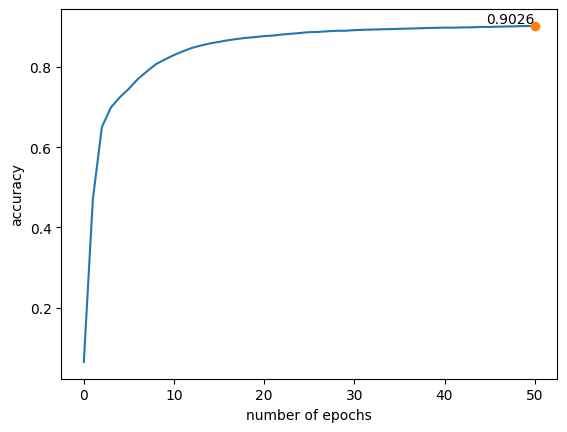

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(accuracy)
plt.plot(len(accuracy)-1, accuracy[-1], 'o') 
plt.text(len(accuracy)-1, accuracy[-1], f'{accuracy[-1]:.4f}', verticalalignment='bottom', horizontalalignment='right')
plt.xlabel('number of epochs')
plt.ylabel('accuracy')

# Visualization

In [12]:
y_preds = model(test_x) # Shape [10000, 10]

# Take the index with has the highest score as the label
y_preds = y_preds.argmax(1) # Shape [10000]

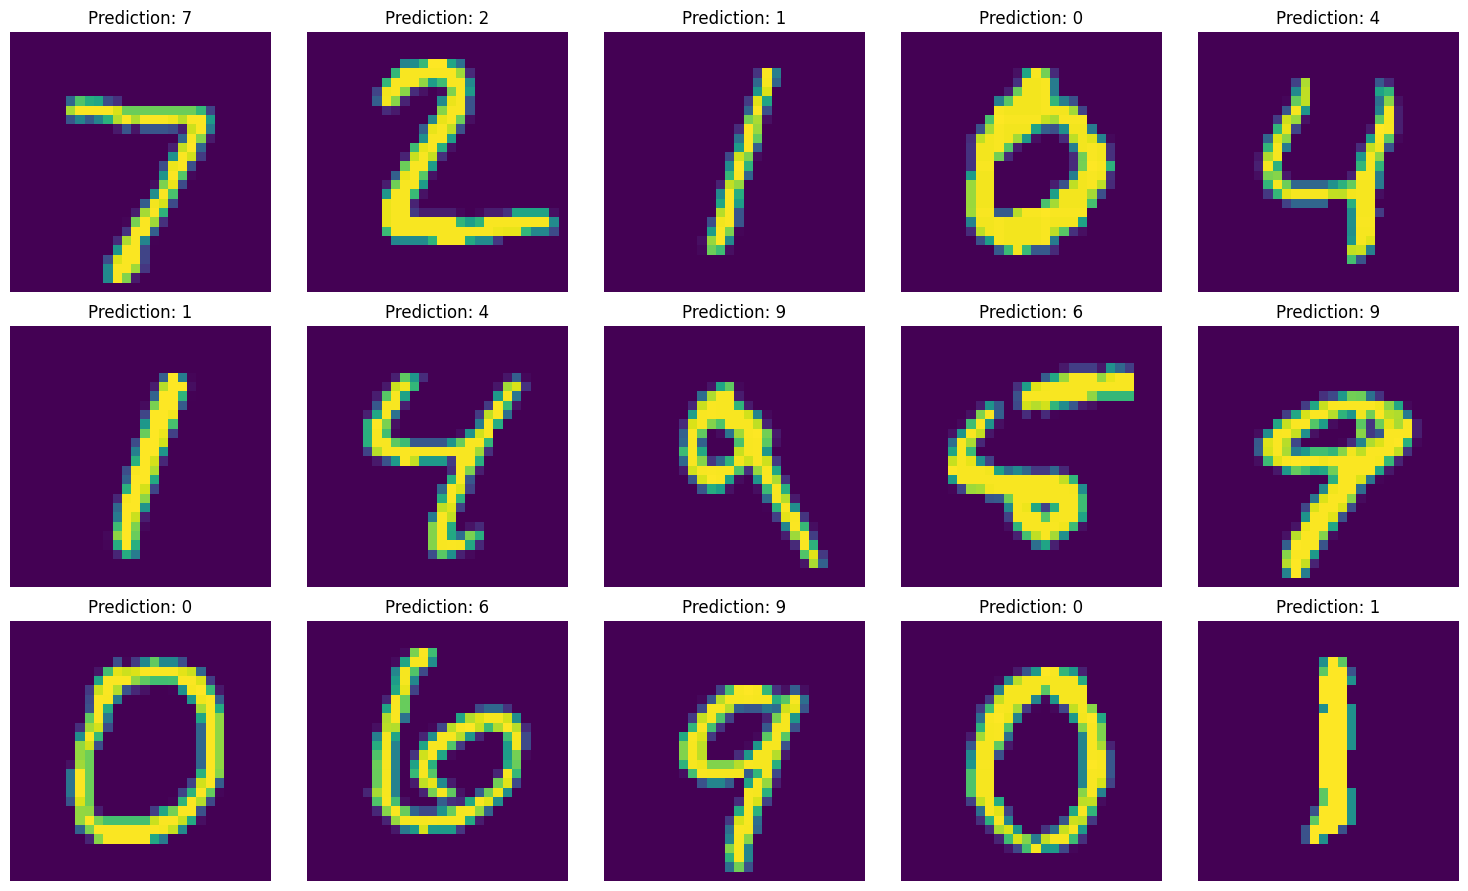

In [13]:
num_items = 15
rows = 3
columns = 5
fig, axs = plt.subplots(rows, columns, figsize=(3 * columns, 3 * rows))

for i in range(num_items):
    row = i // columns
    col = i % columns
    ax = axs[row, col] if rows > 1 else axs[col]
    img = test_x[i].reshape(28, 28)
    ax.imshow(img)
    ax.set_title(f"Prediction: {y_preds[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()